In [29]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import minmax_scale
from sklearn import svm
from scipy.spatial.distance import cdist
from pyts.metrics import dtw
from ipycanvas import Canvas

## Features

In [2]:
def x_value(line):
    return line[1]


def y_value(line):
    return line[2]
 

def pressure_value(line):
    return line[3]


def vx_value(prev_line, current_line):
    x1 = prev_line[1]
    x2 = current_line[1]
    t1 = prev_line[0]
    t2 = current_line[0]

    if t2-t1 == 0:
        return 0
    return (x2-x1)/(t2-t1)


def vy_value(prev_line, current_line):
    y1 = prev_line[2]
    y2 = current_line[2]
    t1 = prev_line[0]
    t2 = current_line[0]
    if t2-t1 == 0:
        return 0
    return (y2-y1)/(t2-t1)


# Compute the "time serie", the features for each line of the signature file
def compute_features_vector(signature, normalize=True):
    rep = []
    first = True
    for line in signature:
        if first:
            prev_line = line
            first = False
        feature_vector = [x_value(line), y_value(line), pressure_value(
            line), vx_value(prev_line, line), vy_value(prev_line, line)]
        rep.append(feature_vector)
        prev_line = line

    array = np.asarray(rep)

    if normalize:
        array = minmax_scale(array, feature_range=(0, 1), axis=0)

    return array

def compute_dtw(signature1, signature2, normalize=True):

    feature_vector_1 = compute_features_vector(signature1, normalize)
    feature_vector_2 = compute_features_vector(signature2, normalize)

    dist_matrix = cdist(feature_vector_1, feature_vector_2)

    dtw_cost = dtw(precomputed_cost=dist_matrix, dist="precomputed",
                   method="sakoechiba")

    return dtw_cost


### Data preprocessing
We take the data contained in the enrollment txt files and store them in a dict (_users_signatures_), such that we reduce I/O calls in the rest of the code.

In [3]:
sig_gt = {}
n_users = 30

with open('data/users.txt', 'r') as f:
    users = [line[:-1] for line in f]
    
assert(len(users)==n_users), f'there should be {n_users} users'

for user in users:
    for i in range (1,6):
        sig = f'0{i}' if i < 10 else f'{i}'
        with open(f'data/verification/{user}-{sig}.txt', 'r') as f:
            signature = [np.asarray(line.split(), dtype=float).tolist() for line in f]
            t = (user,sig)
            sig_gt[t] = signature


### Signature drawing

We thought it could be cool to be able to redraw the signature from the given data

In [4]:
df = pd.DataFrame(signature,columns=["timestamp","x","y","pressure","penup","azimuth","inclinaison"])
df

,timestamp,x,y,pressure,penup,azimuth,inclinaison
0,0.00,49.64,32.36,239.0,1.0,350.0,54.0
1,0.01,50.31,33.16,359.0,0.0,349.0,53.0
2,0.02,50.58,32.98,361.0,0.0,347.0,54.0
3,0.03,50.79,32.65,361.0,0.0,347.0,54.0
4,0.04,50.79,32.21,377.0,0.0,346.0,54.0
...,...,...,...,...,...,...,...
452,4.52,59.27,30.04,806.0,0.0,336.0,55.0
453,4.53,58.89,29.69,796.0,0.0,336.0,55.0
454,4.54,59.17,29.90,785.0,0.0,335.0,54.0
455,4.55,59.89,30.61,748.0,0.0,336.0,55.0


In [5]:
canvas = Canvas(width=500, height=200, layout=dict(width="100%"))

df["x"] = df["x"] - df["x"].min()
df["y"] = df["y"] - df["y"].min()

max_y = df["y"].max() * 10 + 10
old_x = df.iloc[0,1]*10 + 10
old_y = max_y - df.iloc[0,2]*10

counter = 0
for i,row in enumerate(df.itertuples()):

    canvas.stroke_style = "white" if row[4] == 0 else "gray"
    canvas.line_width = row[4]/200
    new_x = row[2]*10 + 10
    new_y = max_y - row[3] * 10
    #print("i {}, {}, {}, {}, {}".format(i,old_x,old_y,row[2]*10,row[3]*10))
    canvas.stroke_line(old_x,old_y,new_x,new_y)
    old_x = new_x
    old_y = new_y
    
canvas

Canvas(height=200, layout=Layout(width='100%'), width=500)

In [6]:
canvas = Canvas(width=500, height=3000, layout=dict(width="100%"))

for i,t in enumerate(sig_gt.keys()):
        
        df = pd.DataFrame(sig_gt[t],columns=["timestamp","x","y","pressure","penup","azimuth","inclinaison"])

        df["x"] = df["x"] - df["x"].min()
        df["y"] = df["y"] - df["y"].min()
        
        x_offset = 10
        y_offset = i * 300 + 10

        max_y = df["y"].max() * 10 + y_offset

        old_x = df.iloc[0,1]*10 + x_offset
        old_y = max_y - df.iloc[0,2]*10

        for row in df.itertuples():

                canvas.stroke_style = "white" if row[4] == 0 else "gray"
                canvas.line_width = row[4]/200
                new_x = row[2]*10 + x_offset
                new_y = max_y - row[3] * 10
                #print("i {}, {}, {}, {}, {}".format(i,old_x,old_y,row[2]*10,row[3]*10))
                canvas.stroke_line(old_x,old_y,new_x,new_y)
                old_x = new_x
                old_y = new_y

        if i >= 10:
                break



canvas


Canvas(height=3000, layout=Layout(width='100%'), width=500)

### DTW values for enrollment
Here we compute the dtw value for each of the 5 signatures made by the users.

In [7]:
def thresh(values): return (9*np.mean(values) + max(values))/10

In [8]:
dtw_gt = {}
# Compute dtw values for the ground truth file (5 signatures/user)
for t in sig_gt.keys():
        u, s = t
        sig = sig_gt[t]
        values = [compute_dtw(sig,sig_gt[(uj,sj)]) for uj,sj in sig_gt.keys() if uj==u and s!=sj]
        dtw_gt[t] = thresh(values)

### Get signatures DTW

In [9]:
sig_ver = {}
for user in users:
    for i in range (1,46):
        sig = f'0{i}' if i < 10 else f'{i}'
        with open(f'data/verification/{user}-{sig}.txt', 'r') as f:
            signature = [np.asarray(line.split(), dtype=float).tolist() for line in f]
            t = (user,sig)
            sig_ver[t] = signature

In [10]:
dtw_ver = {}
for t in sig_ver.keys():
        u, s = t
        sig = sig_ver[t]
        values = [compute_dtw(sig,sig_gt[(uj,sj)]) for uj,sj in sig_gt.keys() if uj==u and s!=sj]
        dtw_ver[t] = thresh(values)

In [11]:
assert(len(dtw_ver)==1350), 'expected length of 1350 was not reached'

In [12]:
# ground truth computation
# false -> forgery
# true -> genuine
with open('data/gt.txt') as file:
    gt = {( line.split(' ')[0].split('-')[0], line.split(' ')[0].split('-')[1]) : True if line.split(' ')[-1][:-1]=='g' else False for line in file}

### SVM to verify signature

In [13]:
# establishing a SVM for each user
classifiers = {}
for user in users :
    xs = []
    ys = []
    for i in range(1,46):
        sig = f'0{i}' if i < 10 else f'{i}'
        t = (user,sig)
        xs.append([dtw_ver[t]])
        ys.append(gt[t])
    clf = svm.SVC()
    clf.fit(xs, ys)
    classifiers[user] = clf

# return True if genuine signature of user is predicted, False else
def sig_verification(user, sig):
    t = (user, sig)
    x = (np.array(dtw_ver[t])).reshape(1, -1)
    return classifiers[user].predict(x)[0]

Accuracy: 88.52 %
Precision: 84.71 %
Recall: 90.5 %
543 98
57 652


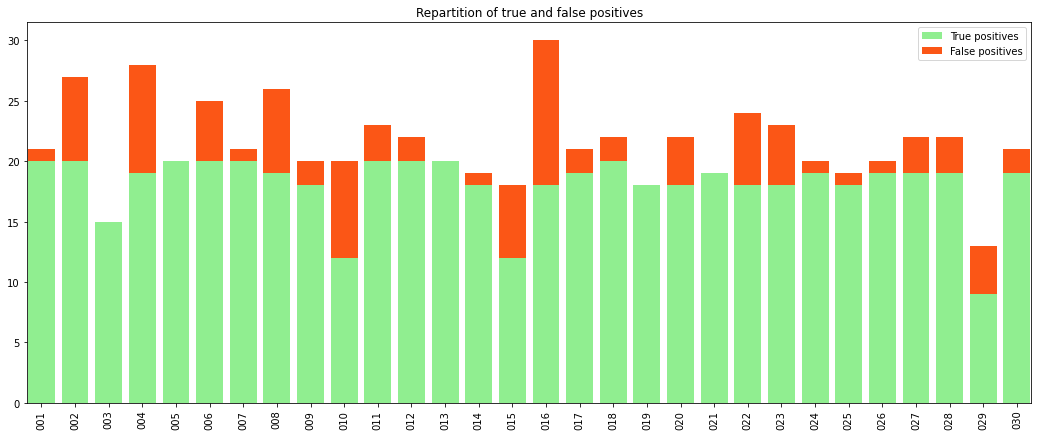

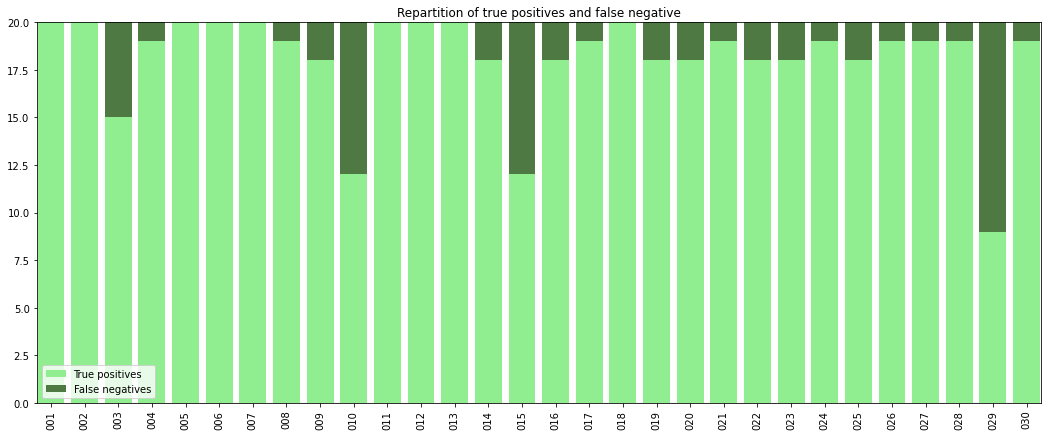

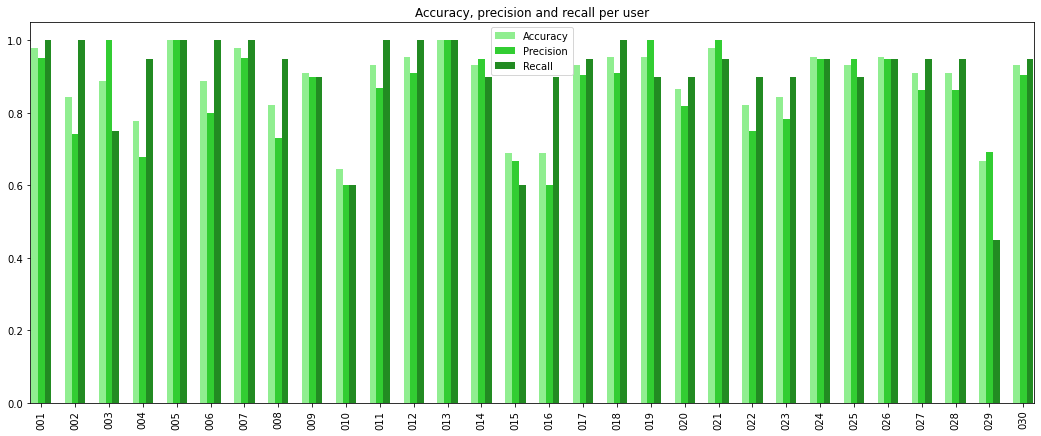

In [14]:
tps = []
fps = []
fns = []
tns = []
for u in users:
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    for i in range(1,46):
        s = f'0{i}' if i < 10 else f'{i}'
        t = (u,s)
        if sig_verification(u, s) and gt[t]:
            tp += 1
        if not sig_verification(u, s) and not gt[t]:
            tn += 1
        if sig_verification(u, s) and not gt[t]:
            fp += 1
        if not sig_verification(u, s) and gt[t]:
            fn += 1
    tps.append(tp)
    fps.append(fp)
    fns.append(fn)
    tns.append(tn)

tps = np.array(tps)
fps = np.array(fps)
fns = np.array(fns)
tns = np.array(tns)
accuracy = (sum(tps) + sum(tns)) / (sum(tps) + sum(tns) + sum(fps) + sum(fns))
accs = (tps + tns) / (tps + tns + fps + fns)
precision = sum(tps) / (sum(tps) + sum(fps))
precs = tps / (tps + fps)
recall = sum(tps) / (sum(tps) + sum(fns))
recs = tps / (tps + fns)

print(f'Accuracy: {round(accuracy*100,2)} %')
print(f'Precision: {round(precision*100,2)} %')
print(f'Recall: {round(recall*100,2)} %')
print(sum(tps), sum(fps))
print(sum(fns), sum(tns))

plt.figure(figsize=(18,7))
plt.xticks(rotation=90)
plt.bar(users, tps, label='True positives', color='#90EE90')
plt.bar(users, fps, bottom=tps, label='False positives', color='#FB5616')
plt.margins(x=0.001)
plt.legend()
plt.title('Repartition of true and false positives')
plt.show()

plt.figure(figsize=(18,7))
plt.xticks(rotation=90)
plt.bar(users, tps, label='True positives', color='#90EE90')
plt.bar(users, fns, bottom=tps, label='False negatives', color='#4F7942')
plt.margins(x=0.001)
plt.legend()
plt.title('Repartition of true positives and false negative')
plt.show()

fig = plt.figure(figsize=(18,7))
X_axis = np.arange(len(users))
plt.xticks(X_axis, users, rotation=90)
plt.bar(X_axis - 0.2, accs, width = 0.2, label='Accuracy', color='lightgreen')
plt.bar(X_axis + 0.0, precs, width = 0.2, label='Precision', color='limegreen')
plt.bar(X_axis + 0.2, recs, width = 0.2, label='Recall', color='forestgreen')
plt.margins(x=0.001)
plt.legend()
plt.title('Accuracy, precision and recall per user')
plt.show()

### Observations

We can see that the accuracy of the model depends highly on the user. Some signatures are less consitent so their dtw value might be higher, even between genuine signatures.

## Competition

### Data preprocessing

In [16]:
sig_gt_c = {}
n_users_c = 70

with open('compet/users.txt', 'r') as f:
    users_c = [line[:-1] for line in f]
    
assert(len(users_c)==n_users_c), f'there should be {n_users_c} users'

for user in users_c:
    for i in range (1,6):
        sig = f'0{i}' if i < 10 else f'{i}'
        with open(f'compet/verification/{user}-{sig}.txt', 'r') as f:
            signature = [np.asarray(line.split(), dtype=float).tolist() for line in f]
            t = (user,sig)
            sig_gt_c[t] = signature

### Get Signatures DTW

In [17]:
sig_ver_c = {}
for user in users_c:
    for i in range (1,46):
        sig = f'0{i}' if i < 10 else f'{i}'
        with open(f'compet/verification/{user}-{sig}.txt', 'r') as f:
            signature = [np.asarray(line.split(), dtype=float).tolist() for line in f]
            t = (user,sig)
            sig_ver_c[t] = signature

In [22]:
# nested dictionnary for easier sort
dtw_ver_c = {}
for user in users_c:
    dtw_user_c = {}
    for i in range (1,46):
        s = f'0{i}' if i < 10 else f'{i}'
        t = (user, s)
        sig = sig_ver_c[t]
        values = [compute_dtw(sig,sig_gt_c[(uj,sj)]) for uj,sj in sig_gt_c.keys() if uj==u and s!=sj]
        dtw_user_c[s] = thresh(values)
    dtw_ver_c[user] = dtw_user_c

### Sorting the results and printing them in a file

In [36]:
with open('sign-ver.csv', 'w', newline='') as f:
    writer = csv.writer(f)
    for user in dtw_ver_c.keys():
        dtw_ver_c[user] = dict(sorted(dtw_ver_c[user].items(), key=lambda item: item[1]))
        row = [user]
        for sig in dtw_ver_c[user]:
            #print(sig, str(dtw_ver_c[user][sig]))
            row += [sig] + [dtw_ver_c[user][sig]]
        writer.writerow(row)